In [1]:
import os
from natsort import natsorted
import random
import tifffile as tiff
import cv2
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
img_dir = "new_dataset/images/"
mask_dir = "new_dataset/masks/"

#img_dir = "new_dataset_Italy/images/"
#mask_dir = "new_dataset_Italy/masks/"

img_list = os.listdir(img_dir)
img_list=natsorted(img_list)

msk_list = os.listdir(mask_dir)
msk_list=natsorted(msk_list)

num_images = len(os.listdir(img_dir))

In [3]:
def reading_images(root_path, files):
    images=[]
    for file in files:
        img=tiff.imread(root_path+file)
        #print(img[:10,0])
        images.append(img)
    return images

In [4]:
masks=reading_images(mask_dir, msk_list)
masks_ar=np.array(masks)
masks_ar=np.expand_dims(masks_ar, axis=-1)

imgs=reading_images(img_dir, img_list)
imgs_ar=np.array(imgs)

In [5]:
imgs_ar.shape, masks_ar.shape

((1303, 128, 128, 14), (1303, 128, 128, 1))

In [6]:
def min_max_scaler_image(image):
    normalized_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        max_value=np.max(image[:,:,i])
        min_value=np.min(image[:,:,i])
        normalized_image[:,:,i] = image[:,:,i]/ max_value
        #normalized_image[:,:,i] = normalized_image[:,:,i] + 0.5
        #normalized_image[:,:,i] = np.clip(normalized_image[:,:,i], 0, 1)
    return normalized_image

In [7]:
def scale_normalize_image(image, means, stds):
    normalized_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        normalized_image[:,:,i] = (image[:,:,i] - means[i]) / (2 * stds[i])
        normalized_image[:,:,i] = normalized_image[:,:,i] + 0.5
        normalized_image[:,:,i] = np.clip(normalized_image[:,:,i], 0, 1)
    return normalized_image

In [8]:
means=[]
stds=[]
for i in range(0,14):
    print(np.mean(imgs_ar[:,:,:,i]), np.max(imgs_ar[:,:,:,i]), np.min(imgs_ar[:,:,:,i]), np.std(imgs_ar[:,:,:,i]))
    means.append(np.mean(imgs_ar[:,:,:,i]))
    stds.append(np.std(imgs_ar[:,:,:,i]))

1052.0874 1905.0 0.0 275.63873
786.344 3638.0 0.0 219.11479
675.8054 3652.0 0.0 205.79753
468.578 4746.0 0.0 216.42885
759.43427 3624.0 0.0 276.08264
1726.8557 4256.0 0.0 584.2288
2134.1873 5584.0 0.0 735.80164
2175.0952 6059.0 0.0 799.70184
994.03235 2989.0 0.0 413.959
14.251601 223.0 0.0 12.503192
1372.7716 5433.0 0.0 603.5555
668.4369 10459.0 0.0 394.17944
18.941736 77.98855 0.0 11.342175
572.7976 2431.891 0.0 425.39337


In [9]:
imgs_norm=[]
for img in imgs_ar:
#    img_std=min_max_scaler_image(img)
    img_std=scale_normalize_image(img, means, stds)
    imgs_norm.append(img_std)  
imgs_norm=np.array(imgs_norm)

imgs_ar=imgs_norm

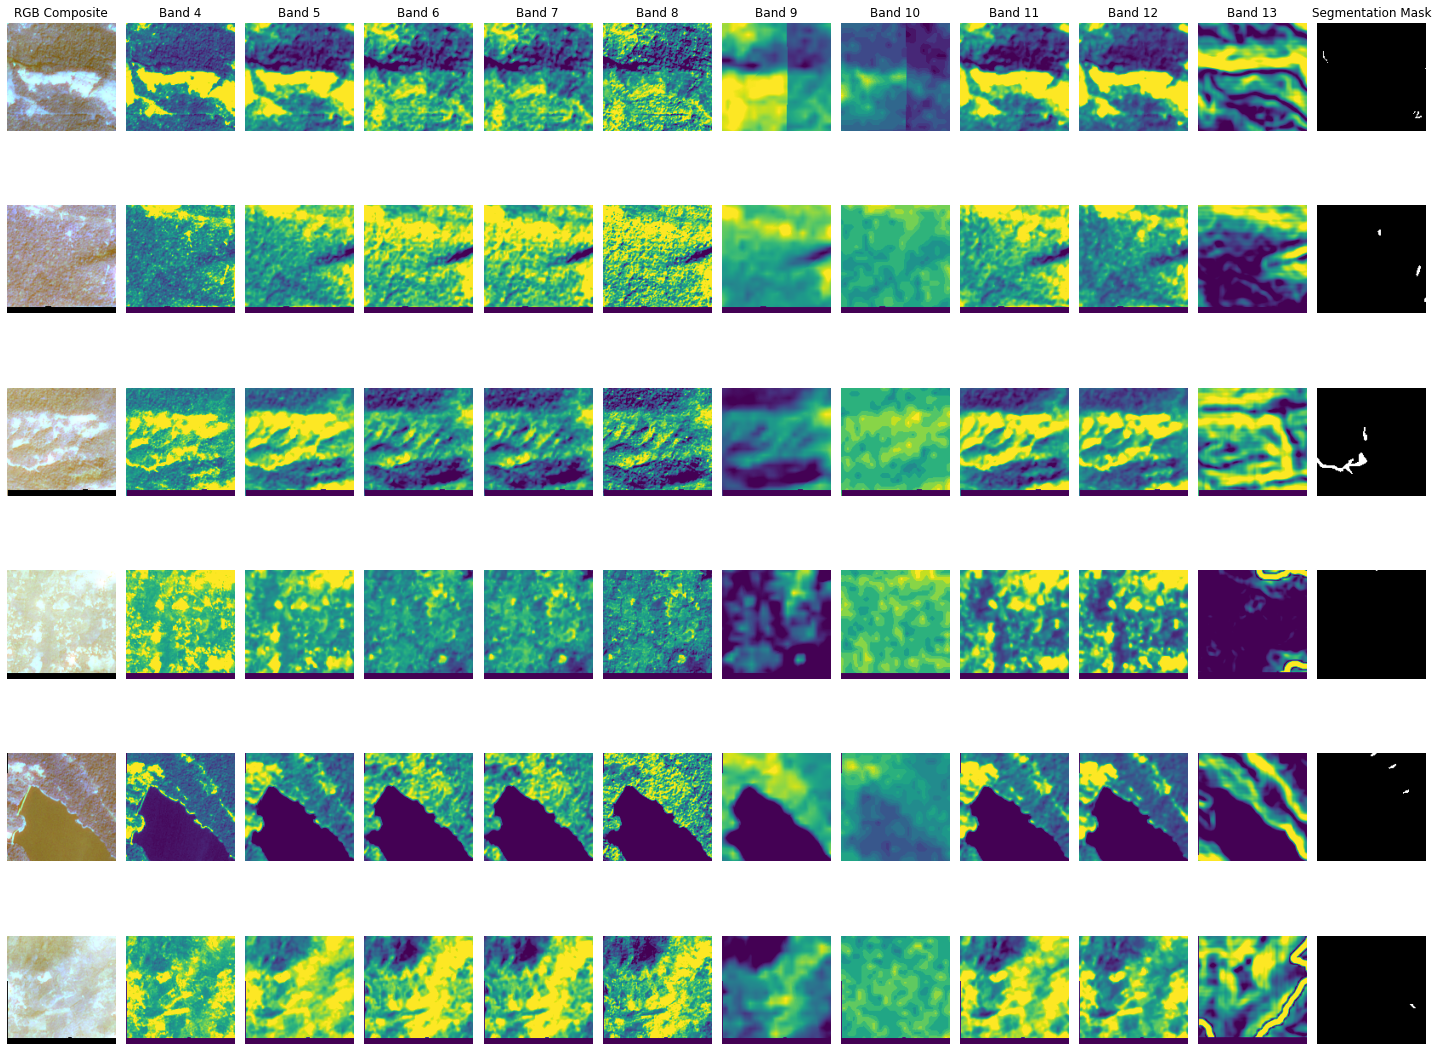

In [10]:
n_random_samples  = 6
n_bands = 14  # Now we have 14 bands in total

#fig, axs = plt.subplots(n_samples_to_plot, 12, figsize=(20, 16))  # 1 RGB composite + 11 individual bands + 1 mask

# Generate random sample indices
random_indices = np.random.choice(np.arange(imgs_ar.shape[0]), size=n_random_samples, replace=False)

# Plotting the random samples
fig, axs = plt.subplots(n_random_samples, 12, figsize=(20, 16))  # Layout configuration

for i, sample_idx in enumerate(random_indices):
    # Create an RGB composite image from the first 3 bands for the selected sample
    rgb_image = imgs_ar[sample_idx, :, :, :3]
    rgb_image /= rgb_image.max()  # Normalizing to [0, 1] for displaying as RGB
    axs[i, 0].imshow(rgb_image)
    axs[i, 0].axis('off')  # Hide axis
    if i == 0:
        axs[i, 0].set_title('RGB Composite', size='large')
    
    for band_idx in range(3, n_bands):  # Starting from the 4th band
        axs[i, band_idx-2].imshow(imgs_ar[sample_idx, :, :, band_idx])#, cmap='gray')
        axs[i, band_idx-2].axis('off')  # Hide axis
        if i == 0:
            axs[0, band_idx-2].set_title(f'Band {band_idx+1}', size='large')

    # Plotting the segmentation mask for the selected sample
    axs[i, 11].imshow(masks_ar[sample_idx, :, :], cmap='gray')
    axs[i, 11].axis('off')
    if i == 0:
        axs[0, 11].set_title('Segmentation Mask', size='large')

plt.tight_layout()
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(imgs_ar, masks_ar, test_size=0.3, random_state=42)

In [12]:
np.unique(y_test), np.unique(y_train)

(array([0, 1], dtype=uint8), array([0, 1], dtype=uint8))

In [13]:
from keras_unet_collection import models
from keras_unet_collection import losses
import segmentation_models as sm
from tensorflow.python.framework import ops
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow import keras
from datetime import datetime 


Segmentation Models: using `keras` framework.


In [14]:
model = models.r2_unet_2d((X_train.shape[-3], X_train.shape[-2], X_train.shape[-1]), [64, 128, 256, 512, 1024], n_labels=1,
                          stack_num_down=2, stack_num_up=2, recur_num=2,
                          activation='ReLU', output_activation='Sigmoid', 
                          batch_norm=True, pool='max', unpool='nearest', name='r2unet')

In [15]:
model.summary()

Model: "r2unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 r2unet_input (InputLayer)      [(None, 128, 128, 1  0           []                               
                                4)]                                                               
                                                                                                  
 r2unet_down0_conv (Conv2D)     (None, 128, 128, 64  960         ['r2unet_input[0][0]']           
                                )                                                                 
                                                                                                  
 r2unet_down0_conv0 (Conv2D)    (None, 128, 128, 64  36928       ['r2unet_down0_conv[0][0]']      
                                )                                                      

In [16]:
def jaccard_coef(y_true, y_pred):
    # Cast tensors to float32
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
    
    # Calculate the intersection
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    
    # Calculate the sum of both predictions and true values, then subtract intersection to get union
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    
    # Smooth term to avoid division by zero
    smooth = 1.0
    
    # Compute Jaccard index
    jaccard_index = (intersection + smooth) / (union + smooth)
    return jaccard_index

def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

In [17]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [18]:
filepath = ("Models/"+model.name+"_best-model.hdf5")

In [19]:
checkpoint = ModelCheckpoint(filepath, monitor='val_iou_score', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.3, patience=10, verbose=1, cooldown=10, min_lr=1e-5)
lr_shceduler = LearningRateScheduler(lambda _, lr: lr * np.exp(-0.01), verbose=1)
tensorboard = keras.callbacks.TensorBoard("logs/1_r2a", update_freq=1)

callbacks_list = [reduce_lr, lr_shceduler, tensorboard, checkpoint]

In [20]:
model.compile(#optimizer=keras.optimizers.SGD(lr=1e-3), 
#              optimizer = 'adam',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#              loss = 'binary_crossentropy',
              loss=jaccard_coef_loss,  
              #loss=losses.iou_seg,
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True),
              metrics=['accuracy', 
                       losses.iou_seg, 
                       tf.keras.metrics.MeanIoU(num_classes=2), 
                       tf.keras.metrics.Recall(), 
                       sm.metrics.iou_score,
                       tf.keras.metrics.Precision()])

In [21]:
callback = [tf.keras.callbacks.LearningRateScheduler(scheduler), checkpoint]


In [22]:
start1 = datetime.now() 

model_history = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=150, 
                    validation_data=(X_test, y_test),
                    #callbacks=callbacks_list,
                    callbacks=[callback],
                    shuffle=False)
#model.save(model.name+'.hdf5')
stop1 = datetime.now()
execution_time_model = stop1-start1
print(model.name+" execution time is: ", execution_time_model)

Epoch 1/150
114/114 [==============================] - ETA: 0s - loss: -0.0214 - accuracy: 0.9305 - iou_seg: 0.9789 - mean_io_u: 0.5028 - recall: 0.2560 - iou_score: 0.0211 - precision: 0.0163
Epoch 1: val_iou_score improved from -inf to 0.00426, saving model to Models\r2unet_model_best-model.hdf5
114/114 [==============================] - 42s 274ms/step - loss: -0.0214 - accuracy: 0.9305 - iou_seg: 0.9789 - mean_io_u: 0.5028 - recall: 0.2560 - iou_score: 0.0211 - precision: 0.0163 - val_loss: -0.0043 - val_accuracy: 0.0047 - val_iou_seg: 0.9957 - val_mean_io_u: 0.0031 - val_recall: 1.0000 - val_iou_score: 0.0043 - val_precision: 0.0043 - lr: 0.0010
Epoch 2/150
114/114 [==============================] - ETA: 0s - loss: -0.0025 - accuracy: 0.9957 - iou_seg: 1.0000 - mean_io_u: 0.4979 - recall: 0.0000e+00 - iou_score: 1.2573e-05 - precision: 0.0000e+00
Epoch 2: val_iou_score did not improve from 0.00426
114/114 [==============================] - 27s 239ms/step - loss: -0.0025 - accuracy:

In [23]:
predictions=model.predict(X_test)
predictions.shape

13/13 [==============================] - 4s 172ms/step


(391, 128, 128, 1)

In [24]:
predictions=(predictions>0.5).astype(np.int8)

In [25]:
def compute_iou(predictions, masks):
    intersection = np.logical_and(predictions, masks)
    union = np.logical_or(predictions, masks)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_mean_iou(predictions_list, masks_list):
    num_samples = len(predictions_list)
    total_iou = 0.0

    for i in range(num_samples):
        predictions = predictions_list[i]
        masks = masks_list[i]

        iou = compute_iou(predictions, masks)
        total_iou += iou

    mean_iou = total_iou / num_samples
    return mean_iou

In [26]:
compute_iou(predictions, y_test)

0.11468434866694295

In [27]:

def plot_random_comparison(X_test, y_test, predictions):
    """Plot comparison between a randomly selected test image, its ground truth, and predicted segmentation mask."""
    # Generate a random index
    index = np.random.randint(0, len(X_test))
    print(str(index)+"\n")
    iou=compute_iou(y_test[index], predictions[index])
    
    plt.figure(figsize=(12, 4))
    
    # Plot the test image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[index,:,:,0:3])
    plt.title('Test Image')
    plt.axis('off')
    
    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[index].squeeze(), cmap='gray')  # Use .squeeze() in case your mask has an extra dimension
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[index].squeeze(), cmap='gray')  # Use .squeeze() in case your prediction has an extra dimension
    plt.title(f'Predicted Mask {iou}')
    plt.axis('off')
    
    plt.show()

47



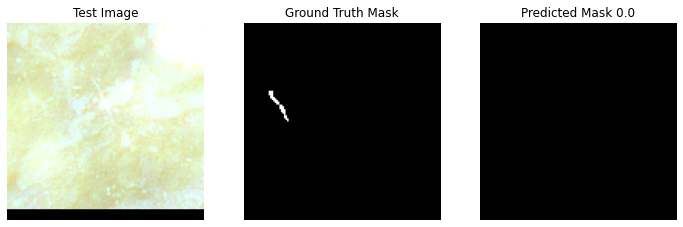

In [28]:
plot_random_comparison(X_test, y_test, predictions)